## Data Preparation, helper functions etc

In [125]:
import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import pingouin as pg
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import linear_model

import random

sns.set_theme(style="white")

In [126]:
# Helper functions
rounding_number = 5

def calc_kcal_adjusted_intake(nutrient, group_by = "user_hash"):
    nutrient_name = nutrient.split('_')[0]

    temp_result = df.groupby(group_by)[nutrient].sum() / df.groupby(group_by)["actual_kcal"].sum() * 1000 #per total 1000 KCAL
    temp_result = pd.merge(temp_result.rename(f"adjusted_{nutrient_name}_intake"), user_hash_diab, how="left", left_on=['user_hash'], right_on=['user_hash']) #merge it with NL level info
    temp_result.dropna(inplace=True)

    return temp_result

wm = lambda x: np.average(x, weights=df.loc[x.index, "actual_kcal"])


# Helper functions for statistical tests
def check_normality(values_list):
    i = 1
    for values_item in values_list:
        print("Group no. " + str(i) + ":")
        values_item = [x for x in values_item if np.isnan(x) != True]
        print("n = " + str(len(values_item)))

        if len(values_item)>=50: #use shapiro wilk with small sample sizes, and D'Agostino with >=50
            print(pg.normality(values_item, method='normaltest').round(rounding_number)) #Using D'agostino's test by setting method to normaltest
        else:
            try:
                stat, p_val = stats.shapiro(values_item)
                print("Shapiro-Wilk p-val: " + str(round(p_val, rounding_number)))
                if p_val >0.05:
                    print("Normal: True\n")
                else:
                    print("Normal: False\n")
            except:
                print("Error: Too few samples for Shapir-Wilk-Test in this group!\n")
        i += 1
    
    min_list_len = min([len(i) for i in values_list]) #get amount of samples in smallest group examined
    if min_list_len >= 100:
        print("Attention: Sample size of smallest group >100 (n="+str(min_list_len)+"), hence normality assumption can be neglected!\n")


def check_normality_silent(values_list):
    normaly_status = False
    i = 1
    for values_item in values_list:
        values_item = [x for x in values_item if np.isnan(x) != True]
        if len(values_item)>=50: #use shapiro wilk with small sample sizes, and D'Agostino with >=50
            p_val = pg.normality(values_item, method='normaltest').iloc[0]["pval"] #Using D'agostino's test by setting method to normaltest
        else:
            stat, p_val = stats.shapiro(values_item)
        if p_val >0.05:
            normality_status = True
        else:
            normality_status = False
        i += 1
    
    return normality_status


def shortcut_ttest(values_group1, values_group2):
    print(f"Mean Group 1 = {round(np.mean(values_group1),rounding_number)}, SD Group 1 = {round(np.std(values_group1),rounding_number)}")
    print(f"Mean Group 2 = {round(np.mean(values_group2),rounding_number)}, SD Group 2 = {round(np.std(values_group2),rounding_number)}")

    stats_ttest = pg.ttest(x=values_group1, y=values_group2, correction= True) 
    #using pg's implementation of t tests will always use welch's t test when sample sizes are unequal, or by setting correction to 'True'

    p_val = stats_ttest["p-val"][0]
    stat = stats_ttest["T"][0]
    dof = stats_ttest["dof"][0]
    conf_int = stats_ttest["CI95%"][0]

    #Evaluation
    print('t statistic: %.5f' % stat) # It is the ratio of the mean of the difference to the standard error of the difference
    print('p-value: %f' % p_val)
    print('Degrees of Freedom: %f' % dof)

    print("Confidence Interval: "+ str(conf_int))
    if p_val < 0.05:
        print("\x1b[31m\"=> Statistically significant difference between the two groups found\"\x1b[0m")
    else:
        print("=> No statistically significant difference")


def shortcut_mwu(values_group1, values_group2):
    print(f"Mean Group 1 = {round(np.mean(values_group1),rounding_number)}, SD Group 1 = {round(np.std(values_group1),rounding_number)}")
    print(f"Median Group 1 = {round(np.median(values_group1),rounding_number)}, IQR Group 1 = {round(np.percentile(values_group1,75) - np.percentile(values_group1,25), rounding_number)}")
    print(f"n Group 1: {len(values_group1)}")
    print(f"Mean Group 2 = {round(np.mean(values_group2),rounding_number)}, SD Group 2 = {round(np.std(values_group2),rounding_number)}")
    print(f"Median Group 2 = {round(np.median(values_group2),rounding_number)}, IQR Group 2 = {round(np.percentile(values_group2,75) - np.percentile(values_group2,25), rounding_number)}")
    print(f"n Group 2: {len(values_group2)}")
    
    results = pg.mwu(values_group1, values_group2)
    print(results)
    p_val = results.iloc[0][2]
    
    if p_val < 0.05:
        print("\x1b[31m\"=> Statistically significant difference between the two groups found\"\x1b[0m") # "\x1b[31m\" for Red text
    else:
        print("=> No statistically significant difference")

In [127]:
# Loading digital receipts data
df_DR = pd.read_csv("../data/receipts_nutr_matched.csv")

df_DR = df_DR.rename(columns={"r2n_user": "user_hash"})

# Loading survey data
df_survey = pd.read_csv("../data/survey_data_final.csv")

# Convert external id to proper format 
df_survey["bitsAboutMeToken"] = df_survey["bitsAboutMeToken"].str.split('external_id=').str[1].str.split('&').str[0]  #remove everyhting before external_id and after &...

df_survey.tail(6)

,1_Age,1_Diabetes_A1cvalue,1_Diabetes_treatment,1_Educational_level,1_Gender,1_Height,1_Target_group,1_Target_group2,1_Therapy_for_adipositas,1_Weight,...,generalScore,packagedFoodsScore,targetGroup,timestamp,userId,BMI,mealsScore,generalScore_type1,diabetes_detail,relative_NL_level
773,50-59,NaN,NaN,Vocational apprenticeship,female,165.0,"No, I do not have diabetes",Obesity (actually or in the past),Exercise,110.0,...,0.428571,0.166667,obese,2020-11-20 16:01:49.476,z7WFeoTnYiZN1BSeFrou01wlKbI3,40.404040,0.625,0.625,none,high
774,40-49,NaN,NaN,University/other tertiary,female,174.0,"No, I do not have diabetes",None of them,NaN,63.0,...,0.357143,0.500000,healthy,2020-11-30 17:05:25.797,zF0Rz7GnuTOsMGSS3xC0olA6e3n1,20.808561,0.250,0.250,none,low
775,40-49,NaN,NaN,Vocational apprenticeship,female,160.0,"No, I do not have diabetes",None of them,NaN,78.0,...,0.214286,0.166667,healthy,2021-08-18 14:49:14.818,zFUr97bLFwQaPpj1Z5TxqrHfGXw1,30.468750,0.250,0.250,none,low
776,18-30,NaN,NaN,Gymnasium- High School level,female,165.0,"No, I do not have diabetes",None of them,NaN,54.0,...,0.142857,0.333333,healthy,2020-12-04 16:54:19.791,zGYRdeDgWphPeCpgDPQqpiIbkQz1,19.834711,0.000,0.000,none,low
777,18-30,NaN,NaN,University/other tertiary,male,188.0,"No, I do not have diabetes",None of them,NaN,86.0,...,0.428571,0.166667,healthy,2020-10-19 16:12:33.541,zcbPkcIWntSibdJtowSQsW6a2T03,24.332277,0.625,0.625,none,high
778,31-39,6.5,['Diet'],University/other tertiary,female,162.0,"Yes, other type of diabetes",None of them,NaN,50.0,...,0.071429,0.166667,diabetes_type2,2020-10-23 15:52:14.812,zqRtvLjdj5NxfGgbx3skztMUVK92,19.051974,0.000,0.000,other_type,low


In [128]:
matching_list2 = pd.read_csv("../data/matching_list_bamid_userhash.csv")
matching_list2

,bam_id,external_id,user_hash
0,1b775983-395f-4ab0-8c12-76d009fdf150,pvf9usgp,NaN
1,920054a7-4549-4d30-b30a-176477e4d98b,dyeee0pr,NaN
2,e1043932-9378-4a03-8c9e-bfebdcbe66a6,2xkesqby,NaN
3,223a4af2-936a-43b9-a721-57a64ea2c0b8,76lefd75,NaN
4,a6f3b760-a7ce-4f3c-8267-d1e159c00952,6irna0pf,NaN
...,...,...,...
56,b0316759-8e72-40dd-81ca-ef0380d0fcea,441fti0g,NaN
57,b2cb3243-a0c6-4de9-9579-1074fe4aec87,wtv3dlhu,NaN
58,47d2f953-0dcc-49c4-be98-3f224ddfab90,custom_001,b150561d2dad1bb7b5e7db1e1846c185
59,81e23e56-c2ec-41e0-acb7-a5721f50c42a,custom_002,9e7ebb2222b6eda6177412728ff1b37b


In [130]:
#merge it (i.e. add bam_id and external id to DR df) based on newly created list (unifying the IDs)
df = pd.merge(df_DR, matching_list2, how="left", on=["user_hash"])

### Data Cleaning 2 ###
# Remove rows without any Nutri Score or energy measure
df.dropna(subset=['nutri_score_calculated', 'energyKcal', "actual_kcal"], inplace=True)
# remove rows with negative values
df = df[df['actual_quantity'] >= 0]

df.reset_index(drop=True, inplace=True)

df.shape

(16839, 43)

In [131]:
### Calculating Nutriscore Manually (because data from EatFit only supplies letters (= scores already converted to 5-scale categories))
# Values based on official calculation guidelines for FSA-NPS DI

#(df is digital receipts data)

value_kj_conversion = 4.1868

def calc_negative_points_food(row_input):
    neg_points = 0

    # energy
    if row_input["energyKcal"] <= 335/value_kj_conversion:
        neg_points = 0
    elif row_input["energyKcal"] <= 670/value_kj_conversion:
        neg_points = 1
    elif row_input["energyKcal"] <= 1005/value_kj_conversion:
        neg_points = 2
    elif row_input["energyKcal"] <= 1340/value_kj_conversion:
        neg_points = 3
    elif row_input["energyKcal"] <= 1675/value_kj_conversion:
        neg_points = 4
    elif row_input["energyKcal"] <= 2010/value_kj_conversion:
        neg_points = 5
    elif row_input["energyKcal"] <= 2345/value_kj_conversion:
        neg_points = 6
    elif row_input["energyKcal"] <= 2680/value_kj_conversion:
        neg_points = 7
    elif row_input["energyKcal"] <= 3015/value_kj_conversion:
        neg_points = 8
    elif row_input["energyKcal"] <= 3350/value_kj_conversion:
        neg_points = 9
    else:
        neg_points = 10
    
    # sugar
    if row_input["sugars"] <= 4.5:
        neg_points += 0
    elif row_input["sugars"] <= 9:
        neg_points += 1
    elif row_input["sugars"] <= 13.5:
        neg_points += 2
    elif row_input["sugars"] <= 18:
        neg_points += 3
    elif row_input["sugars"] <= 22.5:
        neg_points += 4
    elif row_input["sugars"] <= 27:
        neg_points += 5
    elif row_input["sugars"] <= 31:
        neg_points += 6
    elif row_input["sugars"] <= 36:
        neg_points += 7
    elif row_input["sugars"] <= 40:
        neg_points += 8
    elif row_input["sugars"] <= 45:
        neg_points += 9
    else:
        neg_points += 10

    # saturated fatty accids
    if row_input["saturatedFat"] <= 1:
        neg_points += 0
    elif row_input["saturatedFat"] <= 2:
        neg_points += 1
    elif row_input["saturatedFat"] <= 3:
        neg_points += 2
    elif row_input["saturatedFat"] <= 4:
        neg_points += 3
    elif row_input["saturatedFat"] <= 5:
        neg_points += 4
    elif row_input["saturatedFat"] <= 6:
        neg_points += 5
    elif row_input["saturatedFat"] <= 7:
        neg_points += 6
    elif row_input["saturatedFat"] <= 8:
        neg_points += 7
    elif row_input["saturatedFat"] <= 8:
        neg_points += 8
    elif row_input["saturatedFat"] <= 10:
        neg_points += 9
    else:
        neg_points += 10

    # sodium
    if row_input["sodium"] <= 90/1000:
        neg_points += 0
    elif row_input["sodium"] <= 180/1000:
        neg_points += 1
    elif row_input["sodium"] <= 270/1000:
        neg_points += 2
    elif row_input["sodium"] <= 360/1000:
        neg_points += 3
    elif row_input["sodium"] <= 450/1000:
        neg_points += 4
    elif row_input["sodium"] <= 540/1000:
        neg_points += 5
    elif row_input["sodium"] <= 630/1000:
        neg_points += 6
    elif row_input["sodium"] <= 720/1000:
        neg_points += 7
    elif row_input["sodium"] <= 810/1000:
        neg_points += 8
    elif row_input["sodium"] <= 900/1000:
        neg_points += 9
    else:
        neg_points += 10
    
    return neg_points


def calc_negative_points_drinks(row_input):
    neg_points = 0

    # energy
    if row_input["energyKcal"] <= 0/value_kj_conversion:
        neg_points = 0
    elif row_input["energyKcal"] <= 30/value_kj_conversion:
        neg_points = 1
    elif row_input["energyKcal"] <= 60/value_kj_conversion:
        neg_points = 2
    elif row_input["energyKcal"] <= 90/value_kj_conversion:
        neg_points = 3
    elif row_input["energyKcal"] <= 120/value_kj_conversion:
        neg_points = 4
    elif row_input["energyKcal"] <= 150/value_kj_conversion:
        neg_points = 5
    elif row_input["energyKcal"] <= 180/value_kj_conversion:
        neg_points = 6
    elif row_input["energyKcal"] <= 210/value_kj_conversion:
        neg_points = 7
    elif row_input["energyKcal"] <= 240/value_kj_conversion:
        neg_points = 8
    elif row_input["energyKcal"] <= 270/value_kj_conversion:
        neg_points = 9
    else:
        neg_points = 10
    
    # sugar
    if row_input["sugars"] <= 0:
        neg_points += 0
    elif row_input["sugars"] <= 1.5:
        neg_points += 1
    elif row_input["sugars"] <= 3:
        neg_points += 2
    elif row_input["sugars"] <= 4.5:
        neg_points += 3
    elif row_input["sugars"] <= 6:
        neg_points += 4
    elif row_input["sugars"] <= 7.5:
        neg_points += 5
    elif row_input["sugars"] <= 9:
        neg_points += 6
    elif row_input["sugars"] <= 10.5:
        neg_points += 7
    elif row_input["sugars"] <= 12:
        neg_points += 8
    elif row_input["sugars"] <= 13.5:
        neg_points += 9
    else:
        neg_points += 10

    return neg_points


def calc_pos_points_food(row_input):
    pos_points = 0

    # fibre
    if row_input["dietaryFiber"] <= 0.9:
        fibre_points = 0
    elif row_input["dietaryFiber"] <= 1.9:
        fibre_points = 1
    elif row_input["dietaryFiber"] <= 2.8:
        fibre_points = 2
    elif row_input["dietaryFiber"] <= 3.7:
        fibre_points = 3
    elif row_input["dietaryFiber"] <= 4.7:
        fibre_points = 4
    else:
        fibre_points = 5

     # protein
    if row_input["protein"] <= 1.6:
        protein_points = 0
    elif row_input["protein"] <= 3.2:
        protein_points = 1
    elif row_input["protein"] <=4.8:
        protein_points = 2
    elif row_input["protein"] <=6.4:
        protein_points = 3
    elif row_input["protein"] <=8:
        protein_points = 4
    else:
        protein_points = 5

     # FVNP points
    if row_input["health_percentage"] <= 40:
        fnvp_points = 0
    elif row_input["health_percentage"] <= 60:
        fnvp_points = 1
    elif row_input["health_percentage"] <= 80:
        fnvp_points = 2
    else:
        fnvp_points = 5

    pos_points = fibre_points + protein_points + fnvp_points

    return pos_points, fnvp_points, fibre_points, protein_points



def calc_pos_points_drinks(row_input):
    pos_points = 0

    # fibre
    if row_input["dietaryFiber"] <= 0.9:
        fibre_points = 0
    elif row_input["dietaryFiber"] <= 1.9:
        fibre_points = 1
    elif row_input["dietaryFiber"] <= 2.8:
        fibre_points = 2
    elif row_input["dietaryFiber"] <= 3.7:
        fibre_points = 3
    elif row_input["dietaryFiber"] <= 4.7:
        fibre_points = 4
    else:
        fibre_points = 5

     # protein
    if row_input["protein"] <= 1.6:
        protein_points = 0
    elif row_input["protein"] <= 3.2:
        protein_points = 1
    elif row_input["protein"] <=4.8:
        protein_points = 2
    elif row_input["protein"] <=6.4:
        protein_points = 3
    elif row_input["protein"] <=8:
        protein_points = 4
    else:
        protein_points = 5

     # FVNP points
    if row_input["health_percentage"] <= 40:
        fnvp_points = 0
    elif row_input["health_percentage"] <= 60:
        fnvp_points = 2
    elif row_input["health_percentage"] <= 80:
        fnvp_points = 4
    else:
        fnvp_points = 10

    pos_points = fibre_points + protein_points + fnvp_points

    return pos_points, fnvp_points, fibre_points, protein_points

In [132]:
#create GTIN dictionary with nutriscores (in order not to calculate the same item's score more than once)
gtin_nutriscore_dict = dict()


def calc_nutriscore(df_input=df):
    for index, row in df_input.iterrows():

        if row["gtin"] in gtin_nutriscore_dict:
            continue
        else:
            #check if food or drink, then calculate negative points
            if row["major"] == "Soft drinks":
                neg_points_current_row = calc_negative_points_drinks(row)
                pos_points_current_row = calc_pos_points_drinks(row)
            else:
                neg_points_current_row = calc_negative_points_food(row)
                pos_points_current_row = calc_pos_points_food(row)
    
            #determine calculation logic as appropriate
            if "cheese" in str(row["minor"]).lower():
                final_score = neg_points_current_row - pos_points_current_row[0]
            else:
                if neg_points_current_row >= 11:
                    if pos_points_current_row[1] == 5: #fnvp_points
                        final_score = neg_points_current_row - pos_points_current_row[0] # "nutritional score is equal to the total N component points minus the total for the P component"
                    else: 
                        final_score = neg_points_current_row - (pos_points_current_row[2] + pos_points_current_row[1])  #fibrepoints + fnvp_points #"In this case, the protein content is therefore not taken into account in the calculation"

                else:
                    final_score = neg_points_current_row - pos_points_current_row[0] #pos_points
               
            gtin_nutriscore_dict[row["gtin"]] = final_score


calc_nutriscore()

# Adding Nutri-Score calculation to receipts df
df["nutri_score_calculated_numeric"] = df["gtin"].map(gtin_nutriscore_dict)

In [133]:
### Data Transformation etc ###

# Add NL & diabetes information to digital receipts df
df_to_append = df_survey[["relative_NL_level", "bitsAboutMeToken", "diabetes_detail", '1_Age', '1_Educational_level', '1_Gender', 'BMI', '1_Weight', '1_Height', '1_Target_group', '1_Target_group2']].copy().dropna()
df_to_append = df_to_append.drop_duplicates(subset=['bitsAboutMeToken'])

df = pd.merge(df, df_to_append, how="left", left_on=['external_id'], right_on=['bitsAboutMeToken'])
df.head()

,user_hash,receipttype,business_unit,article_id,gtin,quantity_unit,quantity,price,discount,real_price,...,bitsAboutMeToken,diabetes_detail,1_Age,1_Educational_level,1_Gender,BMI,1_Weight,1_Height,1_Target_group,1_Target_group2
0,e023cc56e306daa6c52457bd8c26a68f,json,migros,Eier Freiland 6x53g+,7610200313737,units,1.0,2.95,0.0,2.95,...,2aarca7l,none,40-49,University/other tertiary,female,17.783250,52.0,171.0,"No, I do not have diabetes",Other chronic disease
1,08b1325c816ce26691157c2e195f47e8,json,migros,Eier Freiland 6x53g+,7610200313737,units,1.0,3.20,0.0,3.20,...,dyggo8y6,none,31-39,University/other tertiary,female,19.957284,57.0,169.0,"No, I do not have diabetes",None of them
2,ad2b13a3cf56cd3408ce586dc679c6f9,json,migros,Eier Freiland 6x53g+,7610200313737,units,1.0,3.20,0.0,3.20,...,b6dysl6r,none,50-59,Vocational apprenticeship,female,40.404040,110.0,165.0,"No, I do not have diabetes",Obesity (actually or in the past)
3,ad2b13a3cf56cd3408ce586dc679c6f9,json,migros,Eier Freiland 6x53g+,7610200313737,units,1.0,3.20,0.0,3.20,...,b6dysl6r,none,50-59,Vocational apprenticeship,female,40.404040,110.0,165.0,"No, I do not have diabetes",Obesity (actually or in the past)
4,ad2b13a3cf56cd3408ce586dc679c6f9,json,migros,Eier Freiland 6x53g+,7610200313737,units,1.0,3.20,0.0,3.20,...,b6dysl6r,none,50-59,Vocational apprenticeship,female,40.404040,110.0,165.0,"No, I do not have diabetes",Obesity (actually or in the past)


In [134]:
# Creating FSA-NPS Dietary Index (for ALL participants, irreleveant whether NL informatin available)
# Very quick explanation: The formula is the arithmetic energy-weighted means of the nutri score of each item
# (i.e. score adjusted for energy; (score*Energy) / Sum of Energy  )

fsa_nps_DI_per_user = df.groupby('user_hash').agg(dietary_index=("nutri_score_calculated_numeric", wm))

fsa_nps_DI_per_user

,dietary_index
user_hash,
08b1325c816ce26691157c2e195f47e8,6.934585
2a73dd2176d7ad1c97e543a8445b03aa,2.943513
41204cb8eab3c4d5f68a331eafc6b679,7.043556
41bbfa584c3d9bb561135a21382043e6,6.664068
427305f00d23f2394459a12eb3cb996c,4.309712
4e17666101ca1ac6c02484960cf2fe3f,6.911349
5821f23829a701cca4df0fea568c76e8,6.385195
743cdb91be1c9ccf4d81c68b009e37bf,13.498247
947cc49c1fff0077044244d5687d9eb9,-1.541276


In [135]:
# Adding NL information to the fsa_nps_data (= filtering out users with no NL information (survey))
f = lambda x: np.nan if x.isnull().all() else x.value_counts().index[0]
user_hash_diab = df.groupby('user_hash')['relative_NL_level'].apply(f).reset_index()

fsa_nps_DI_per_user_NL = pd.merge(fsa_nps_DI_per_user, user_hash_diab, how="left", left_on=['user_hash'], right_on=['user_hash'])
fsa_nps_DI_per_user_NL.dropna(inplace=True)
fsa_nps_DI_per_user_NL = fsa_nps_DI_per_user_NL.reset_index()

fsa_nps_DI_per_user_NL.shape

(11, 4)

***

## General statistics about food purchasing behavior

In [136]:
# Unfiltered baskets statistics

print("Users with purchase data (unfiltered): " + str(df['user_hash'].nunique()))
print("total baskets: " + str(df.groupby(["user_hash", "receipt_datetime"]).ngroup().nunique()))
print("total items: " + str(df.shape[0]))

df_temp = df.copy()
df_temp["basket_id"] = df_temp.groupby(["user_hash", "receipt_datetime"]).ngroup()
print("mean basket size: " + str(np.mean(df_temp.groupby(['basket_id']).size())))


Users with purchase data (unfiltered): 19
total baskets: 1535
total items: 16839
mean basket size: 10.970032573289902


In [137]:
# Filtered baskets statistics

df_filtered_nl = df[df['bitsAboutMeToken'].notna()].copy()

df_filtered_nl

print("Users with purchase data (with NL info): " + str(df_filtered_nl['user_hash'].nunique()))
print("total baskets: " + str(df_filtered_nl.groupby(["user_hash", "receipt_datetime"]).ngroup().nunique()))
print("total items: " + str(df_filtered_nl.shape[0]))

df_filtered_nl["basket_id"] = df_filtered_nl.groupby(["user_hash", "receipt_datetime"]).ngroup()
print("mean basket size: " + str(  np.mean(df_filtered_nl.groupby(['basket_id']).size())  ))
print("SD basket size: " + str(  np.std(df_filtered_nl.groupby(['basket_id']).size())  ))

Users with purchase data (with NL info): 11
total baskets: 1176
total items: 13299
mean basket size: 11.308673469387756
SD basket size: 11.65931321454547


In [138]:
#General FSA-NPS statistics (only of those who also have NL information provided)

# Total
print("Total")
print("Mean FSA-NPS DI: " + str(round(fsa_nps_DI_per_user_NL["dietary_index"].mean(),2))  +"\nSTD: " + str(round(fsa_nps_DI_per_user_NL["dietary_index"].std(), 2)))
check_normality([fsa_nps_DI_per_user_NL["dietary_index"]])

# Low NL
print("\n Low NL")
print("Mean FSA-NPS DI: " + str(round(fsa_nps_DI_per_user_NL[fsa_nps_DI_per_user_NL["relative_NL_level"]=="low"]["dietary_index"].mean(),2))  +"\nSTD: " + 
    str(round(fsa_nps_DI_per_user_NL[fsa_nps_DI_per_user_NL["relative_NL_level"]=="low"]["dietary_index"].std(), 2)))
check_normality([fsa_nps_DI_per_user_NL[fsa_nps_DI_per_user_NL["relative_NL_level"]=="low"]["dietary_index"]])

# High NL
print("\n High NL")
print("Mean FSA-NPS DI: " + str(round(fsa_nps_DI_per_user_NL[fsa_nps_DI_per_user_NL["relative_NL_level"]=="high"]["dietary_index"].mean(),2))  +"\nSTD: " + 
    str(round(fsa_nps_DI_per_user_NL[fsa_nps_DI_per_user_NL["relative_NL_level"]=="high"]["dietary_index"].std(), 2)))
check_normality([fsa_nps_DI_per_user_NL[fsa_nps_DI_per_user_NL["relative_NL_level"]=="high"]["dietary_index"]])


Total
Mean FSA-NPS DI: 5.49
STD: 2.58
Group no. 1:
n = 11
Shapiro-Wilk p-val: 0.19914
Normal: True


 Low NL
Mean FSA-NPS DI: 6.74
STD: 0.31
Group no. 1:
n = 3
Shapiro-Wilk p-val: 0.07143
Normal: True


 High NL
Mean FSA-NPS DI: 5.01
STD: 2.92
Group no. 1:
n = 8
Shapiro-Wilk p-val: 0.76216
Normal: True



In [139]:
### Participants with NL & Food data // Total statistics
# (Divided subgroups by total, high NL, Low NL)
# Also checking for a normal distribution (relevant for how to report)

print("Participants with NL & Food data: " + str(  df_filtered_nl['user_hash'].nunique()  ))


print("\nTotal NL")
print("  Amount of items bought total:   Mean = " + str(  np.mean(df_filtered_nl.groupby(['user_hash']).size())  ) + "    SD = " + str(  np.std(df_filtered_nl.groupby(['user_hash']).size())   ))
check_normality([df_filtered_nl.groupby(['user_hash']).size()])

print("low NL")
print("  Amount of items bought total:   Mean = " + str(  np.mean(df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['user_hash']).size())  ) + "    SD = " + str(  np.std(df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['user_hash']).size())   ))
check_normality([df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['user_hash']).size()])

print("high NL")
print("  Amount of items bought total:   Mean = " + str(  np.mean(df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['user_hash']).size())  ) + "    SD = " + str(  np.std(df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['user_hash']).size())   ))
check_normality([df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['user_hash']).size()])

Participants with NL & Food data: 11

Total NL
  Amount of items bought total:   Mean = 1209.0    SD = 1139.3411174087337
Group no. 1:
n = 11
Shapiro-Wilk p-val: 0.06071
Normal: True

low NL
  Amount of items bought total:   Mean = 1112.0    SD = 779.8337429649134
Group no. 1:
n = 3
Shapiro-Wilk p-val: 0.93245
Normal: True

high NL
  Amount of items bought total:   Mean = 1245.375    SD = 1245.785187893563
Group no. 1:
n = 8
Shapiro-Wilk p-val: 0.06796
Normal: True



In [140]:
print("\nTotal NL")
print("  Amount of items bought per basket:   Mean = " + str(  np.mean(df_filtered_nl.groupby(['basket_id']).size())  ) + "    SD = " + str(  np.std(df_filtered_nl.groupby(['basket_id']).size())   ))
check_normality([df_filtered_nl.groupby(['basket_id']).size()])

print("low NL")
print("  Amount of items bought per basket:   Mean = " + str(  np.mean(df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['basket_id']).size())  ) + "    SD = " + str(  np.std(df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['basket_id']).size())   ))
check_normality([df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['basket_id']).size()])

print("high NL")
print("  Amount of items bought per basket:   Mean = " + str(  np.mean(df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['basket_id']).size())  ) + "    SD = " + str(  np.std(df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['basket_id']).size())   ))
check_normality([df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['basket_id']).size()])


Total NL
  Amount of items bought per basket:   Mean = 11.308673469387756    SD = 11.65931321454547
Group no. 1:
n = 1176
          W  pval  normal
0  705.8789   0.0   False
Attention: Sample size of smallest group >100 (n=1176), hence normality assumption can be neglected!

low NL
  Amount of items bought per basket:   Mean = 12.49438202247191    SD = 12.858309016368592
Group no. 1:
n = 267
           W  pval  normal
0  221.92613   0.0   False
Attention: Sample size of smallest group >100 (n=267), hence normality assumption can be neglected!

high NL
  Amount of items bought per basket:   Mean = 10.96039603960396    SD = 11.259249919690198
Group no. 1:
n = 909
           W  pval  normal
0  464.76726   0.0   False
Attention: Sample size of smallest group >100 (n=909), hence normality assumption can be neglected!



In [141]:
# => Non-normal reporting
print("\nTotal NL")
print("  Amount of items bought per basket:   median = " + str(  np.median(df_filtered_nl.groupby(['basket_id']).size())  ) + "    IQR = " + str(np.nanpercentile(df_filtered_nl.groupby(['basket_id']).size(), [25, 75])) )

print("low NL")
print("  Amount of items bought per basket:   median = " + str(  np.median(df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['basket_id']).size())  ) + "    IQR = " + str(  np.nanpercentile(df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['basket_id']).size(), [25, 75]   )))

print("high NL")
print("  Amount of items bought per basket:   median = " + str(  np.median(df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['basket_id']).size())  ) + "    IQR = " + str(  np.nanpercentile(df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['basket_id']).size(), [25, 75]   )))



Total NL
  Amount of items bought per basket:   median = 8.0    IQR = [ 4. 15.]
low NL
  Amount of items bought per basket:   median = 8.0    IQR = [ 4. 17.]
high NL
  Amount of items bought per basket:   median = 8.0    IQR = [ 3. 14.]


In [142]:
print("\nTotal NL")
print("  KCAL bought total:   Mean = " + str(  np.mean( df_filtered_nl.groupby(['user_hash'])['actual_kcal'].agg('sum') )  ) + "    SD = " + str(  np.std( df_filtered_nl.groupby(['user_hash'])['actual_kcal'].agg('sum') )   ))
check_normality([df_filtered_nl.groupby(['user_hash'])['actual_kcal'].agg('sum')])


print("low NL")
print("  KCAL bought total:   Mean = " + str(  np.mean( df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['user_hash'])['actual_kcal'].agg('sum') )  ) + "    SD = " + str(  np.std( df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['user_hash'])['actual_kcal'].agg('sum') )   ))
check_normality([df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['user_hash'])['actual_kcal'].agg('sum')])

print("high NL")
print("  KCAL bought total:   Mean = " + str(  np.mean( df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['user_hash'])['actual_kcal'].agg('sum') )  ) + "    SD = " + str(  np.std( df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['user_hash'])['actual_kcal'].agg('sum') )   ))
check_normality([df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['user_hash'])['actual_kcal'].agg('sum')])


Total NL
  KCAL bought total:   Mean = 654793.5289200002    SD = 549434.1055137324
Group no. 1:
n = 11
Shapiro-Wilk p-val: 0.12359
Normal: True

low NL
  KCAL bought total:   Mean = 711982.6621666657    SD = 429581.25326592487
Group no. 1:
n = 3
Shapiro-Wilk p-val: 0.30325
Normal: True

high NL
  KCAL bought total:   Mean = 633347.6039525005    SD = 586679.7281502545
Group no. 1:
n = 8
Shapiro-Wilk p-val: 0.03326
Normal: False



In [143]:
# Reporting for non normal variable
print("high NL")
print("  KCAL bought total:   Median = " + str(  np.median( df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['user_hash'])['actual_kcal'].agg('sum') )  ) + "    IQR = " + 
    str(np.nanpercentile( df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['user_hash'])['actual_kcal'].agg('sum')      , [25, 75]   )))

high NL
  KCAL bought total:   Median = 422476.95098999934    IQR = [254277.6675  826867.34835]


In [144]:
print("\nTotal NL")
print("  KCAL bought per basket:   Mean = " + str(  np.mean( df_filtered_nl.groupby(['basket_id'])['actual_kcal'].agg('sum') )  ) + "    SD = " + str(  np.std( df_filtered_nl.groupby(['basket_id'])['actual_kcal'].agg('sum') )   ))
check_normality([df_filtered_nl.groupby(['basket_id'])['actual_kcal'].agg('sum') ])

print("low NL")
print("  KCAL bought per basket:   Mean = " + str(  np.mean( df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['basket_id'])['actual_kcal'].agg('sum') )  ) + "    SD = " + str(  np.std( df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['basket_id'])['actual_kcal'].agg('sum') )   ))
check_normality([df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['basket_id'])['actual_kcal'].agg('sum')])

print("high NL")
print("  KCAL bought per basket:   Mean = " + str(  np.mean( df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['basket_id'])['actual_kcal'].agg('sum') )  ) + "    SD = " + str(  np.std( df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['basket_id'])['actual_kcal'].agg('sum') )   ))
check_normality([df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['basket_id'])['actual_kcal'].agg('sum')])

# => Non-normal, report with median and IQR instead


Total NL
  KCAL bought per basket:   Mean = 6124.769403163265    SD = 8119.187304819648
Group no. 1:
n = 1176
            W  pval  normal
0  1023.55223   0.0   False
Attention: Sample size of smallest group >100 (n=1176), hence normality assumption can be neglected!

low NL
  KCAL bought per basket:   Mean = 7999.805192883899    SD = 9813.213659980383
Group no. 1:
n = 267
           W  pval  normal
0  249.43934   0.0   False
Attention: Sample size of smallest group >100 (n=267), hence normality assumption can be neglected!

high NL
  KCAL bought per basket:   Mean = 5574.016316413639    SD = 7460.716633316092
Group no. 1:
n = 909
           W  pval  normal
0  789.81711   0.0   False
Attention: Sample size of smallest group >100 (n=909), hence normality assumption can be neglected!



In [145]:
print("\nTotal NL")
print("  KCAL bought per basket:   Median = " + str(  np.median( df_filtered_nl.groupby(['basket_id'])['actual_kcal'].agg('sum') )  ) + "    IQR = " + str(np.nanpercentile(df_filtered_nl.groupby(['basket_id'])['actual_kcal'].agg('sum'), [25, 75])) )

print("low NL")
print("  KCAL bought per basket:   Median = " + str(  np.median( df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['basket_id'])['actual_kcal'].agg('sum') )  ) + "    IQR = " + str( np.nanpercentile( df_filtered_nl[df_filtered_nl["relative_NL_level"]=="low"].groupby(['basket_id'])['actual_kcal'].agg('sum'), [25, 75])) )

print("high NL")
print("  KCAL bought per basket:   Median = " + str(  np.median( df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['basket_id'])['actual_kcal'].agg('sum') )  ) + "   IQR = " + str(np.nanpercentile( df_filtered_nl[df_filtered_nl["relative_NL_level"]=="high"].groupby(['basket_id'])['actual_kcal'].agg('sum'), [25, 75])) )

# => Non-normal, report with median and IQR instead


Total NL
  KCAL bought per basket:   Median = 3459.628    IQR = [1024.32875 8006.67525]
low NL
  KCAL bought per basket:   Median = 5269.942999999999    IQR = [2191.4    9665.1123]
high NL
  KCAL bought per basket:   Median = 2959.7   IQR = [ 825.    7214.132]


In [146]:
print("\nTotal NL")
print("  Percentage of vegetables in total items:    Mean = " + 
    str( (df_filtered_nl[df_filtered_nl.major=="Vegetables"].groupby("user_hash")["basket_id"].count() / df_filtered_nl.groupby("user_hash")["basket_id"].count() * 100).mean() ) +
    "    SD = " +
    str( (df_filtered_nl[df_filtered_nl.major=="Vegetables"].groupby("user_hash")["basket_id"].count() / df_filtered_nl.groupby("user_hash")["basket_id"].count() * 100).std() )
    )
check_normality([ (df_filtered_nl[df_filtered_nl.major=="Vegetables"].groupby("user_hash")["basket_id"].count() / df_filtered_nl.groupby("user_hash")["basket_id"].count() * 100) ])

print("low NL") 
print("  Percentage of vegetables in total items:    Mean = " + 
    str( (df_filtered_nl[df_filtered_nl.major=="Vegetables"].query('relative_NL_level == "low"').groupby("user_hash")["basket_id"].count() / df_filtered_nl.query('relative_NL_level == "low"').groupby("user_hash")["basket_id"].count() * 100).mean() ) +
    "    SD = " +
    str( (df_filtered_nl[df_filtered_nl.major=="Vegetables"].query('relative_NL_level == "low"').groupby("user_hash")["basket_id"].count() / df_filtered_nl.query('relative_NL_level == "low"').groupby("user_hash")["basket_id"].count() * 100).std() )
    )
check_normality([ (df_filtered_nl[df_filtered_nl.major=="Vegetables"].query('relative_NL_level == "low"').groupby("user_hash")["basket_id"].count() / df_filtered_nl.query('relative_NL_level == "low"').groupby("user_hash")["basket_id"].count() * 100) ])

print("high NL")
print("  Percentage of vegetables in total items:    Mean = " + 
    str( (df_filtered_nl[df_filtered_nl.major=="Vegetables"].query('relative_NL_level == "high"').groupby("user_hash")["basket_id"].count() / df_filtered_nl.query('relative_NL_level == "high"').groupby("user_hash")["basket_id"].count() * 100).mean() ) +
    "    SD = " +
    str( (df_filtered_nl[df_filtered_nl.major=="Vegetables"].query('relative_NL_level == "high"').groupby("user_hash")["basket_id"].count() / df_filtered_nl.query('relative_NL_level == "high"').groupby("user_hash")["basket_id"].count() * 100).std() )
    )
check_normality([ (df_filtered_nl[df_filtered_nl.major=="Vegetables"].query('relative_NL_level == "high"').groupby("user_hash")["basket_id"].count() / df_filtered_nl.query('relative_NL_level == "high"').groupby("user_hash")["basket_id"].count() * 100) ])



Total NL
  Percentage of vegetables in total items:    Mean = 18.707714689987725    SD = 5.087036320647137
Group no. 1:
n = 11
Shapiro-Wilk p-val: 0.028
Normal: False

low NL
  Percentage of vegetables in total items:    Mean = 22.07788019256645    SD = 7.182569341028522
Group no. 1:
n = 3
Shapiro-Wilk p-val: 0.08868
Normal: True

high NL
  Percentage of vegetables in total items:    Mean = 17.443902626520703    SD = 3.9415183187634035
Group no. 1:
n = 8
Shapiro-Wilk p-val: 0.12986
Normal: True



In [147]:
# Reporting for non normal variable
print("\nTotal NL")
print("  Percentage of vegetables in total items:    Median = " + 
    str( (df_filtered_nl[df_filtered_nl.major=="Vegetables"].groupby("user_hash")["basket_id"].count() / df_filtered_nl.groupby("user_hash")["basket_id"].count() * 100).median() ) +
    "    IQR = " + 
    str(np.nanpercentile( df_filtered_nl[df_filtered_nl.major=="Vegetables"].groupby("user_hash")["basket_id"].count() / df_filtered_nl.groupby("user_hash")["basket_id"].count() * 100      , [25, 75]   )))


Total NL
  Percentage of vegetables in total items:    Median = 16.85185185185185    IQR = [14.86354776 22.6663217 ]


In [148]:
print("\nTotal NL")
print("  Percentage of fruits in total items:    Mean = " + 
    str( (df_filtered_nl[df_filtered_nl.major=="Fruit"].groupby("user_hash")["basket_id"].count() / df_filtered_nl.groupby("user_hash")["basket_id"].count() * 100).mean() ) +
    "    SD = " +
    str( (df_filtered_nl[df_filtered_nl.major=="Fruit"].groupby("user_hash")["basket_id"].count() / df_filtered_nl.groupby("user_hash")["basket_id"].count() * 100).std() )
    )
check_normality([ (df_filtered_nl[df_filtered_nl.major=="Fruit"].groupby("user_hash")["basket_id"].count() / df_filtered_nl.groupby("user_hash")["basket_id"].count() * 100) ])


print("low NL") 
print("  Percentage of fruits in total items:    Mean = " + 
    str( (df_filtered_nl[df_filtered_nl.major=="Fruit"].query('relative_NL_level == "low"').groupby("user_hash")["basket_id"].count() / df_filtered_nl.query('relative_NL_level == "low"').groupby("user_hash")["basket_id"].count() * 100).mean() ) +
    "    SD = " +
    str( (df_filtered_nl[df_filtered_nl.major=="Fruit"].query('relative_NL_level == "low"').groupby("user_hash")["basket_id"].count() / df_filtered_nl.query('relative_NL_level == "low"').groupby("user_hash")["basket_id"].count() * 100).std() )
    )
check_normality([ (df_filtered_nl[df_filtered_nl.major=="Fruit"].query('relative_NL_level == "low"').groupby("user_hash")["basket_id"].count() / df_filtered_nl.query('relative_NL_level == "low"').groupby("user_hash")["basket_id"].count() * 100) ])

print("high NL")
print("  Percentage of fruits in total items:    Mean = " + 
    str( (df_filtered_nl[df_filtered_nl.major=="Fruit"].query('relative_NL_level == "high"').groupby("user_hash")["basket_id"].count() / df_filtered_nl.query('relative_NL_level == "high"').groupby("user_hash")["basket_id"].count() * 100).mean() ) +
    "    SD = " +
    str( (df_filtered_nl[df_filtered_nl.major=="Fruit"].query('relative_NL_level == "high"').groupby("user_hash")["basket_id"].count() / df_filtered_nl.query('relative_NL_level == "high"').groupby("user_hash")["basket_id"].count() * 100).std() )
    )
check_normality([ (df_filtered_nl[df_filtered_nl.major=="Fruit"].query('relative_NL_level == "high"').groupby("user_hash")["basket_id"].count() / df_filtered_nl.query('relative_NL_level == "high"').groupby("user_hash")["basket_id"].count() * 100) ])


Total NL
  Percentage of fruits in total items:    Mean = 12.421927968810376    SD = 4.6542056400292795
Group no. 1:
n = 11
Shapiro-Wilk p-val: 0.26428
Normal: True

low NL
  Percentage of fruits in total items:    Mean = 10.818251962996392    SD = 6.4968010865327335
Group no. 1:
n = 3
Shapiro-Wilk p-val: 0.0857
Normal: True

high NL
  Percentage of fruits in total items:    Mean = 13.023306470990622    SD = 4.167748170053855
Group no. 1:
n = 8
Shapiro-Wilk p-val: 0.54118
Normal: True



In [149]:
# Participants with NL & Food data // energy adjusted nutrient statistics (per 1000 KCAL) Part 2: Food groups Vegetables & Fruits

## Vegetables
print("\nTotal NL")
print("  Share (in percent) of KCAL from food group Vegetables:    Mean = " + 
    str( (df[df.major=="Vegetables"].groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).mean() ) +
    "    SD = " +
    str( (df[df.major=="Vegetables"].groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).std())
    )
check_normality([ (df[df.major=="Vegetables"].groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100) ])

print("low NL")
print("  Share (in percent) of KCAL from food group Vegetables:    Mean = " + 
    str( (df[df.major=="Vegetables"].query('relative_NL_level == "low"').groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).mean() ) +
    "    SD = " +
    str(  (df[df.major=="Vegetables"].query('relative_NL_level == "low"').groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).std())
    )
check_normality([ (df[df.major=="Vegetables"].query('relative_NL_level == "low"').groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100) ])


print("high NL")
print("  Share (in percent) of KCAL from food group Vegetables:    Mean = " + 
    str( (df[df.major=="Vegetables"].query('relative_NL_level == "high"').groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).mean() ) +
    "    SD = " +
   str( (df[df.major=="Vegetables"].query('relative_NL_level == "high"').groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).std())
    )
check_normality([ (df[df.major=="Vegetables"].query('relative_NL_level == "high"').groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100) ])




Total NL
  Share (in percent) of KCAL from food group Vegetables:    Mean = 5.095189002050155    SD = 2.164639771138984
Group no. 1:
n = 19
Shapiro-Wilk p-val: 0.03259
Normal: False

low NL
  Share (in percent) of KCAL from food group Vegetables:    Mean = 4.329139995183797    SD = 0.5219431635204962
Group no. 1:
n = 3
Shapiro-Wilk p-val: 0.86408
Normal: True

high NL
  Share (in percent) of KCAL from food group Vegetables:    Mean = 4.700825809046439    SD = 2.335853693234007
Group no. 1:
n = 8
Shapiro-Wilk p-val: 0.02771
Normal: False



In [150]:
# => Reporting in for non-normal data with median & IQR

# Participants with NL & Food data // energy adjusted nutrient statistics (per 1000 KCAL) Part 2: Food groups Vegetables & Fruits

## Vegetables
print("\nTotal NL")
print("  Share (in percent) of KCAL from food group Vegetables:    Median = " + 
    str( (df[df.major=="Vegetables"].groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).median() ) +
    "    IQR = " +
    str( np.nanpercentile(  (df[df.major=="Vegetables"].groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100) , [25, 75])
    ) )

print("high NL")
print("  Share (in percent) of KCAL from food group Vegetables:    Median = " + 
    str( (df[df.major=="Vegetables"].query('relative_NL_level == "high"').groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).median() ) +
    "    IQR = " +
   str( np.nanpercentile(  (df[df.major=="Vegetables"].query('relative_NL_level == "high"').groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100) , [25, 75])
    ) )


Total NL
  Share (in percent) of KCAL from food group Vegetables:    Median = 4.3918420363899475    IQR = [3.3050037  6.58323204]
high NL
  Share (in percent) of KCAL from food group Vegetables:    Median = 3.305003695131166    IQR = [3.10385383 6.41551587]


In [151]:
# ...continued... Participants with NL & Food data // energy adjusted nutrient statistics (per 1000 KCAL) Part 2: Food groups Vegetables & Fruits
## Fruit
print("\nTotal NL")
print("  Share (in percent) of KCAL from food group Fruit:    Mean = " + 
    str( (df[df.major=="Vegetables"].groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).mean() ) +
    "    SD = " +
    str( (df[df.major=="Vegetables"].groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).std() )
    )
check_normality([ (df[df.major=="Vegetables"].groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100) ])


print("low NL")
print("  Share (in percent) of KCAL from food group Fruit:    Mean = " + 
    str( (df[df.major=="Fruit"].query('relative_NL_level == "low"').groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).mean() ) +
    "    SD = " +
    str( (df[df.major=="Fruit"].query('relative_NL_level == "low"').groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).std() )
    )
check_normality([ (df[df.major=="Fruit"].query('relative_NL_level == "low"').groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100) ])


print("high NL")
print("  Share (in percent) of KCAL from food group Fruit:    Mean = " + 
    str( (df[df.major=="Fruit"].query('relative_NL_level == "high"').groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).mean() ) +
    "    SD = " +
    str( (df[df.major=="Fruit"].query('relative_NL_level == "high"').groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).std() )
    )
check_normality([ (df[df.major=="Fruit"].query('relative_NL_level == "high"').groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100) ])
#=> Report with mean (SD)



Total NL
  Share (in percent) of KCAL from food group Fruit:    Mean = 5.095189002050155    SD = 2.164639771138984
Group no. 1:
n = 19
Shapiro-Wilk p-val: 0.03259
Normal: False

low NL
  Share (in percent) of KCAL from food group Fruit:    Mean = 5.498241991358076    SD = 3.609633366910685
Group no. 1:
n = 3
Shapiro-Wilk p-val: 0.95931
Normal: True

high NL
  Share (in percent) of KCAL from food group Fruit:    Mean = 7.975669340747894    SD = 4.17392055359628
Group no. 1:
n = 8
Shapiro-Wilk p-val: 0.51691
Normal: True



In [152]:
# => Reporting in for non-normal data with median & IQR

print("\nTotal NL")
print("  Share (in percent) of KCAL from food group Fruit:    Median = " + 
    str( (df[df.major=="Fruit"].groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100).median() ) +
    "    IQR = " +
    str( np.nanpercentile(  (df[df.major=="Fruit"].groupby("user_hash")["actual_kcal"].sum() / df.groupby("user_hash")["actual_kcal"].sum() * 100) , [25, 75])
    ) )


Total NL
  Share (in percent) of KCAL from food group Fruit:    Median = 6.942270464281162    IQR = [ 4.22838854 10.71695967]


In [153]:
def stats_energyadj_nutrient(nutrient_name, nutrient_short):
    print("\nTotal NL")
    print(f"  {nutrient_short} (g) per 1000 KCAL:    Mean = " + str( calc_kcal_adjusted_intake(nutrient=nutrient_name).iloc[:,1].mean() ) + "    SD = " + str( str( calc_kcal_adjusted_intake(nutrient=nutrient_name).iloc[:,1].std() ) ))
    print("  Normal: " + str(check_normality_silent([  calc_kcal_adjusted_intake(nutrient=nutrient_name).iloc[:,1]  ])))
    
    print("low NL")
    print(f"  {nutrient_short} (g) per 1000 KCAL:    Mean = " + str( calc_kcal_adjusted_intake(nutrient=nutrient_name).query('relative_NL_level == "low"').iloc[:,1].mean() ) + "    SD = " + str( str( calc_kcal_adjusted_intake(nutrient=nutrient_name).query('relative_NL_level == "low"').iloc[:,1].std() ) ))
    print("  Normal: " + str(check_normality_silent([  calc_kcal_adjusted_intake(nutrient=nutrient_name).query('relative_NL_level == "low"').iloc[:,1]  ])))
    
    print("high NL")
    print(f"  {nutrient_short} (g) per 1000 KCAL:    Mean = " + str( calc_kcal_adjusted_intake(nutrient=nutrient_name).query('relative_NL_level == "high"').iloc[:,1].mean() ) + "    SD = " + str( str( calc_kcal_adjusted_intake(nutrient=nutrient_name).query('relative_NL_level == "high"').iloc[:,1].std() ) ))
    print("  Normal: " + str(check_normality_silent([  calc_kcal_adjusted_intake(nutrient=nutrient_name).query('relative_NL_level == "high"').iloc[:,1]  ])))

In [154]:
# Participants with NL & Food data // energy adjusted nutrient statistics (g per 1000 KCAL)
# Why g? Because dietary fiber cannot be reported in KCAL

stats_energyadj_nutrient("totalCarbohydrate_actual_quantity", "Carbs")
stats_energyadj_nutrient("sugars_actual_quantity", "Sugars")
stats_energyadj_nutrient("protein_actual_quantity", "Protein")
stats_energyadj_nutrient("totalFat_actual_quantity", "Total fat")
stats_energyadj_nutrient("saturatedFat_actual_quantity", "Saturated fat")
stats_energyadj_nutrient("sodium_actual_quantity", "Sodium")
stats_energyadj_nutrient("dietaryFiber", "Dietary fiber")


Total NL
  Carbs (g) per 1000 KCAL:    Mean = 108.69974706254716    SD = 16.38911310929231
  Normal: True
low NL
  Carbs (g) per 1000 KCAL:    Mean = 96.36866469581359    SD = 8.274010111019777
  Normal: True
high NL
  Carbs (g) per 1000 KCAL:    Mean = 113.32390295007225    SD = 16.569690401774857
  Normal: True

Total NL
  Sugars (g) per 1000 KCAL:    Mean = 48.3190021393083    SD = 16.955960594284953
  Normal: True
low NL
  Sugars (g) per 1000 KCAL:    Mean = 37.03043652610642    SD = 6.998265585014325
  Normal: True
high NL
  Sugars (g) per 1000 KCAL:    Mean = 52.552214244259005    SD = 17.934160284368517
  Normal: True

Total NL
  Protein (g) per 1000 KCAL:    Mean = 37.04689996411003    SD = 5.082121856259946
  Normal: True
low NL
  Protein (g) per 1000 KCAL:    Mean = 34.17126744497573    SD = 1.7641371274132922
  Normal: True
high NL
  Protein (g) per 1000 KCAL:    Mean = 38.12526215878539    SD = 5.579868901065762
  Normal: True

Total NL
  Total fat (g) per 1000 KCAL:    Me

### Characteristics table reporting for 11 participants of stage 2

In [155]:
#Use existing dataframe and select only the first item per user (since every column contains all the descriptive statistics data)
df_11p = df.groupby('user_hash').first()
df_11p = df_11p[df_11p["relative_NL_level"].notnull()]
df_11p.shape

(11, 54)

In [159]:
# Generate descriptive statistics

relevant_cols = ['1_Age', '1_Diabetes_A1cvalue', '1_Diabetes_treatment', '1_Educational_level', '1_Gender', '1_Height', '1_Target_group', '1_Target_group2', '1_Therapy_for_adipositas', '1_Weight', "BMI", 'packagedFoodsScore']

def describe_categorical(input_col):
    c = df_11p[input_col].value_counts(dropna=False)
    p = round(df_11p[input_col].value_counts(dropna=False, normalize=True)*100, 2)
    print(pd.concat([c,p], axis=1, keys=['counts', '%']))

def describe_numeric(input_col):
    print("Count: " + str(df_11p[input_col].count())  +"     Mean: " + str(round(df_11p[input_col].mean(),2))  +"     STD: " + str(round(df_11p[input_col].std(), 2)))
    q3, q1 = np.percentile(df_11p[input_col], [75 ,25])
    print("Count: " + str(df_11p[input_col].count())  +"     Median: " + str(round(df_11p[input_col].median(),2))  +"     IQR: " + str(round(q3-q1, 2)))

print("---- Age ----")
describe_categorical('1_Age')

print("---- Gender ----")
describe_categorical("1_Gender")

print("---- Weight ----")
describe_numeric("1_Weight")

print("---- Height ----")
describe_numeric("1_Height")

print("---- BMI ----")
describe_numeric("BMI")

print("---- Education ----")
describe_categorical("1_Educational_level")

print("---- Group ----")
describe_categorical("1_Target_group")

print("---- Group2 ----")
describe_categorical("1_Target_group2")

---- Age ----
       counts      %
18-30       5  45.45
50-59       3  27.27
40-49       2  18.18
31-39       1   9.09
---- Gender ----
        counts      %
female       8  72.73
male         3  27.27
---- Weight ----
Count: 11     Mean: 73.09     STD: 15.86
Count: 11     Median: 74.0     IQR: 14.5
---- Height ----
Count: 11     Mean: 171.82     STD: 7.9
Count: 11     Median: 170.0     IQR: 4.5
---- BMI ----
Count: 11     Mean: 24.93     STD: 6.24
Count: 11     Median: 23.74     IQR: 6.88
---- Education ----
                              counts      %
University/other tertiary          7  63.64
Higher vocational education        2  18.18
Gymnasium- High School level       1   9.09
Vocational apprenticeship          1   9.09
---- Group ----
                            counts      %
No, I do not have diabetes      11  100.0
---- Group2 ----
                                   counts      %
None of them                            7  63.64
Other chronic disease                   2  18.18
O

***
## Difference in FSA-NPS DI scores between high and low NL


------- Checking Normality -------
Group no. 1:
n = 3
Shapiro-Wilk p-val: 0.07143
Normal: True

Group no. 2:
n = 8
Shapiro-Wilk p-val: 0.76216
Normal: True



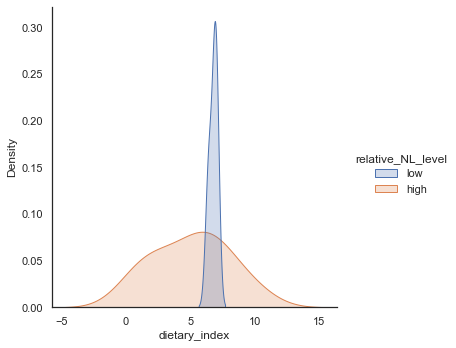

In [44]:
# Independent t-test: Checking Assumptions

values_1 = fsa_nps_DI_per_user_NL[fsa_nps_DI_per_user_NL["relative_NL_level"] =="low"]["dietary_index"]
values_2 = fsa_nps_DI_per_user_NL[fsa_nps_DI_per_user_NL["relative_NL_level"] =="high"]["dietary_index"]

# Assumption no. 1: Normality
print("------- Checking Normality -------")
check_normality([values_1, values_2])

sns.displot(fsa_nps_DI_per_user_NL, x="dietary_index", hue="relative_NL_level", fill=True, kind = "kde")
plt.show()

In [45]:
# Conducting the actual t-test
shortcut_ttest(values_group1=values_1, values_group2=values_2)

Mean Group 1 = 6.74371, SD Group 1 = 0.25369
Mean Group 2 = 5.01418, SD Group 2 = 2.7357
t statistic: 1.64805
p-value: 0.140990
Degrees of Freedom: 7.404223
Confidence Interval: [-0.72  4.18]
=> No statistically significant difference


***

## Correlation of food purchase quality with socio-economic variables recorded in the survey, adjusted for NL 

In [46]:
# Adding all other information to the fsa_nps_data

df_expanded = df.drop_duplicates(['user_hash'])[['user_hash','1_Age', '1_Educational_level', '1_Gender', 'BMI', 'diabetes_detail']].reset_index(drop=True)

fsa_nps_DI_per_user_expanded = pd.merge(fsa_nps_DI_per_user_NL, df_expanded, how="left", left_on=['user_hash'], right_on=['user_hash'])
fsa_nps_DI_per_user_expanded.dropna(inplace=True)
fsa_nps_DI_per_user_expanded = fsa_nps_DI_per_user_expanded.reset_index(drop=True)

# Dummy encoding the variables
fsa_nps_DI_per_user_expanded = pd.get_dummies(fsa_nps_DI_per_user_expanded, columns=['relative_NL_level', '1_Age', '1_Educational_level', '1_Gender'])
fsa_nps_DI_per_user_expanded

,index,user_hash,dietary_index,BMI,diabetes_detail,relative_NL_level_high,relative_NL_level_low,1_Age_18-30,1_Age_31-39,1_Age_40-49,1_Age_50-59,1_Educational_level_Gymnasium- High School level,1_Educational_level_Higher vocational education,1_Educational_level_University/other tertiary,1_Educational_level_Vocational apprenticeship,1_Gender_female,1_Gender_male
0,0,08b1325c816ce26691157c2e195f47e8,6.934585,19.957284,none,0,1,0,1,0,0,0,0,1,0,1,0
1,2,41204cb8eab3c4d5f68a331eafc6b679,7.043556,21.736505,none,1,0,1,0,0,0,0,0,1,0,1,0
2,3,41bbfa584c3d9bb561135a21382043e6,6.664068,25.951557,none,1,0,0,0,0,1,0,0,1,0,1,0
3,5,4e17666101ca1ac6c02484960cf2fe3f,6.911349,28.075043,none,0,1,1,0,0,0,0,0,1,0,0,1
4,6,5821f23829a701cca4df0fea568c76e8,6.385195,27.016860,none,0,1,1,0,0,0,0,0,1,0,0,1
5,10,9e7ebb2222b6eda6177412728ff1b37b,3.359296,23.738662,none,1,0,0,0,1,0,0,1,0,0,1,0
6,11,ad2b13a3cf56cd3408ce586dc679c6f9,1.064279,40.404040,none,1,0,0,0,0,1,0,0,0,1,1,0
7,13,c65337d215ad9dea8f99a40855a26573,6.167515,20.775623,none,1,0,1,0,0,0,0,0,1,0,0,1
8,14,d73cfdedf06f43266c95bd4d857e738c,9.555012,28.196921,none,1,0,0,0,0,1,0,1,0,0,1,0
9,15,d7c8b0c7f6778e2fc6f456845918455c,1.450428,20.549887,none,1,0,1,0,0,0,1,0,0,0,1,0


In [47]:
def multiple_linear_reg_1predictor(predictor, data_df):
    #ax = sns.regplot(x="dietary_index", y=predictor, data=data_df).set_title("Attention: Plot Unadjusted for NL Level")

    # OLS
    X = data_df[['relative_NL_level_high', predictor]] 
    y = data_df['dietary_index']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(model.summary())
    return model


def verify_linreg_assumptions(model_name):
    # Linear relationship
    # Assumed

    # Expected Mean of Residuals is 0
    print("Residual mean (should be 0): ")
    print(round(model_name.resid.mean(), 4))

    # Residuals are normally distributed (QQ Plot)
    print("\n Checking normality of residuals:")

    #print(pg.normality(model_name.resid, method='normaltest').round(rounding_number))
    stat, p_val = stats.shapiro(model_name.resid) #using shapiro-wilk test throughout due to small sample size in NL part of analysis (19 users)
    print("Shapiro-Wilk p-val: " + str(round(p_val, rounding_number)))
    if p_val >0.05:
        print("Normal: True\n")
    else:
        print("Normal: False\n")
    # sm.ProbPlot(model_name.resid).qqplot(line='s'); # USING Q Q Plots depreciated in favor of d'agostinos test
    # plt.title('Q-Q plot');
    # plt.show()

    # No autocorrelation of residuas
    print("\n Checking no autocorrelation of residuals:")
    print("Durbin-Watson Test: " + str(round(sms.durbin_watson(model_name.resid), 4)))
    print("A value around 2 indiciates no autocorrelation")

    # Assuming Homoscedasticity of Residuals
    print("\n Checking Homoscedasticity of residuals:")
    lm, lm_pval, fval, f_pval  = sms.het_breuschpagan(model_name.resid, model_name.model.exog)
    print('Breusch-Pagan test')
    print("p-val: " + str(round(lm_pval, 4)))
    if lm_pval > 0.05: # if result is not significant, then cannot reject null hypothesis stating that homoscedasticity is present
        print("Homoscedasticity is present (assumption verified)\n")
    else:
        print("Heteroscedasticity could be present (assumption violated)\n")

In [48]:
print("Gender correlation while adjusting for NL level\n")

model_gender = multiple_linear_reg_1predictor(predictor="1_Gender_male", data_df=fsa_nps_DI_per_user_expanded)

Gender correlation while adjusting for NL level

                            OLS Regression Results                            
Dep. Variable:          dietary_index   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                 -0.116
Method:                 Least Squares   F-statistic:                    0.4794
Date:                Wed, 29 Jun 2022   Prob (F-statistic):              0.636
Time:                        09:19:42   Log-Likelihood:                -24.890
No. Observations:                  11   AIC:                             55.78
Df Residuals:                       8   BIC:                             56.97
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/Users/marcbloech/opt/anaconda3/envs/env_3_8_8/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [49]:
verify_linreg_assumptions(model_gender)

Residual mean (should be 0): 
-0.0

 Checking normality of residuals:
Shapiro-Wilk p-val: 0.83282
Normal: True


 Checking no autocorrelation of residuals:
Durbin-Watson Test: 2.1056
A value around 2 indiciates no autocorrelation

 Checking Homoscedasticity of residuals:
Breusch-Pagan test
p-val: 0.233
Homoscedasticity is present (assumption verified)



In [50]:
print("BMI correlation while adjusting for NL level\n")

model_bmi = multiple_linear_reg_1predictor(predictor="BMI", data_df=fsa_nps_DI_per_user_expanded)

BMI correlation while adjusting for NL level

                            OLS Regression Results                            
Dep. Variable:          dietary_index   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                 -0.058
Method:                 Least Squares   F-statistic:                    0.7265
Date:                Wed, 29 Jun 2022   Prob (F-statistic):              0.513
Time:                        09:19:42   Log-Likelihood:                -24.594
No. Observations:                  11   AIC:                             55.19
Df Residuals:                       8   BIC:                             56.38
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/Users/marcbloech/opt/anaconda3/envs/env_3_8_8/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [51]:
verify_linreg_assumptions(model_bmi)

Residual mean (should be 0): 
-0.0

 Checking normality of residuals:
Shapiro-Wilk p-val: 0.95415
Normal: True


 Checking no autocorrelation of residuals:
Durbin-Watson Test: 2.2024
A value around 2 indiciates no autocorrelation

 Checking Homoscedasticity of residuals:
Breusch-Pagan test
p-val: 0.3206
Homoscedasticity is present (assumption verified)



***
## Compliance with food intake limit recommendations by nutrition literacy level

In [52]:
# nutrient per 1000 KCAL

adjusted_sugar_consumption = calc_kcal_adjusted_intake(nutrient="sugars_actual_quantity")
print(adjusted_sugar_consumption)

adjusted_sodium_consumption = calc_kcal_adjusted_intake(nutrient="sodium_actual_quantity")
print(adjusted_sodium_consumption)

adjusted_satfat_consumption = calc_kcal_adjusted_intake(nutrient="saturatedFat_actual_quantity") 
print(adjusted_satfat_consumption)

                           user_hash  adjusted_sugars_intake relative_NL_level
0   08b1325c816ce26691157c2e195f47e8               42.963018               low
2   41204cb8eab3c4d5f68a331eafc6b679               34.106317              high
3   41bbfa584c3d9bb561135a21382043e6               56.389614              high
5   4e17666101ca1ac6c02484960cf2fe3f               29.312401               low
6   5821f23829a701cca4df0fea568c76e8               38.815891               low
10  9e7ebb2222b6eda6177412728ff1b37b               65.507451              high
11  ad2b13a3cf56cd3408ce586dc679c6f9               83.750971              high
13  c65337d215ad9dea8f99a40855a26573               50.866528              high
14  d73cfdedf06f43266c95bd4d857e738c               52.209247              high
15  d7c8b0c7f6778e2fc6f456845918455c               52.463356              high
16  e023cc56e306daa6c52457bd8c26a68f               25.124230              high
                           user_hash  adjusted_sodiu

#### Sugar consumption: T-test

------- Checking Normality -------


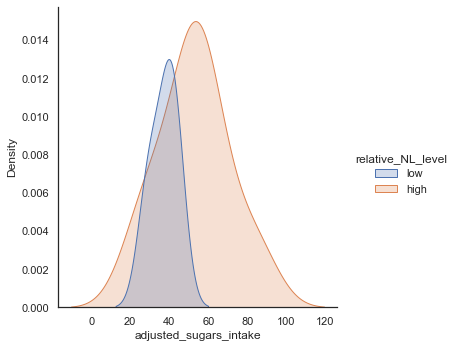

Group no. 1:
n = 3
Shapiro-Wilk p-val: 0.57451
Normal: True

Group no. 2:
n = 8
Shapiro-Wilk p-val: 0.76833
Normal: True


------- T-test results -------
Mean Group 1 = 37.03044, SD Group 1 = 5.71406
Mean Group 2 = 52.55221, SD Group 2 = 16.77587
t statistic: -2.06445
p-value: 0.069775
Degrees of Freedom: 8.775015
Confidence Interval: [-32.6    1.55]
=> No statistically significant difference


In [53]:
### Testing sugar consumption ###

# Independent t-test: Checking Assumptions

# Assumption no. 1: Normality
print("------- Checking Normality -------")
sns.displot(adjusted_sugar_consumption, x="adjusted_sugars_intake", hue="relative_NL_level", kind="kde", fill=True)
plt.show()

values_1 = adjusted_sugar_consumption[adjusted_sugar_consumption["relative_NL_level"] =="low"]["adjusted_sugars_intake"]
values_2 = adjusted_sugar_consumption[adjusted_sugar_consumption["relative_NL_level"] =="high"]["adjusted_sugars_intake"]

check_normality([values_1, values_2])

# Running t-test
print("\n------- T-test results -------")
shortcut_ttest(values_group1 = values_1, values_group2 = values_2)

#### Sodium consumption: T-test

------- Checking Normality -------


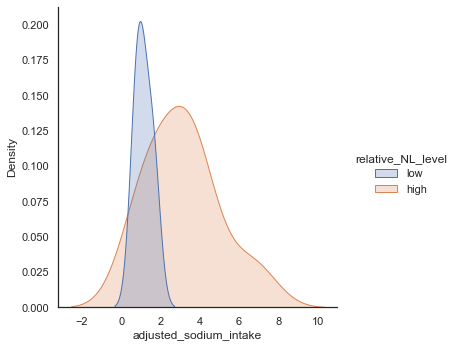

Group no. 1:
n = 3
Shapiro-Wilk p-val: 0.62647
Normal: True

Group no. 2:
n = 8
Shapiro-Wilk p-val: 0.34219
Normal: True


------- T-test results -------
Mean Group 1 = 1.12412, SD Group 1 = 0.3642
Mean Group 2 = 3.11801, SD Group 2 = 1.71819
t statistic: -2.85407
p-value: 0.019774
Degrees of Freedom: 8.627918
Confidence Interval: [-3.58 -0.4 ]
"=> Statistically significant difference between the two groups found"


In [54]:
### Testing sodium consumption ###

# Independent t-test: Checking Assumptions

# Assumption no. 1: Normality
print("------- Checking Normality -------")
sns.displot(adjusted_sodium_consumption, x="adjusted_sodium_intake", hue="relative_NL_level", kind="kde", fill=True)
plt.show()


values_1 = adjusted_sodium_consumption[adjusted_sodium_consumption["relative_NL_level"] =="low"]["adjusted_sodium_intake"]
values_2 = adjusted_sodium_consumption[adjusted_sodium_consumption["relative_NL_level"] =="high"]["adjusted_sodium_intake"]

check_normality([values_1, values_2])


# Running t-test
print("\n------- T-test results -------")
shortcut_ttest(values_group1 = values_1, values_group2 = values_2)

In [55]:
# Additional analysis of sodium consumption

#calculate amount of items containing "salz" in the name, divided by number of participants = average amount of salt items bought per person per NL level
print(df.groupby(['relative_NL_level'])['article_id'].apply(lambda x: x[x.str.contains('salz')].count()))

print(f"Salt items per high NL participant {24/8}")
print(f"Salt items per low NL participant {3/3}")

relative_NL_level
high    24
low      3
Name: article_id, dtype: int64
Salt items per high NL participant 3.0
Salt items per low NL participant 1.0


#### Saturated fats consumption: T-test

------- Checking Normality -------


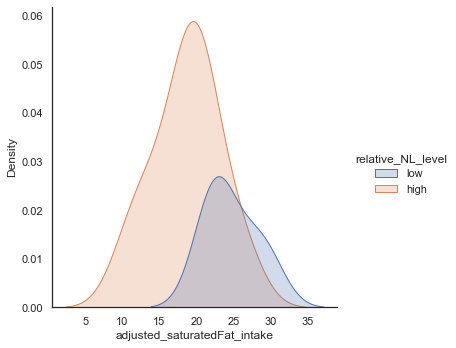

Group no. 1:
n = 3
Shapiro-Wilk p-val: 0.17094
Normal: True

Group no. 2:
n = 8
Shapiro-Wilk p-val: 0.92828
Normal: True


------- T-test results -------
Mean Group 1 = 24.6405, SD Group 1 = 2.87296
Mean Group 2 = 18.66532, SD Group 2 = 4.21067
t statistic: 2.31537
p-value: 0.071752
Degrees of Freedom: 4.702186
Confidence Interval: [-0.79 12.74]
=> No statistically significant difference


In [56]:
### Testing saturated fats consumption ###

# Independent t-test: Checking Assumptions

# Assumption no. 1: Normality
print("------- Checking Normality -------")
sns.displot(adjusted_satfat_consumption, x="adjusted_saturatedFat_intake", hue="relative_NL_level", kind="kde", fill=True)
plt.show()

values_1 = adjusted_satfat_consumption[adjusted_satfat_consumption["relative_NL_level"] =="low"]["adjusted_saturatedFat_intake"]
values_2 = adjusted_satfat_consumption[adjusted_satfat_consumption["relative_NL_level"] =="high"]["adjusted_saturatedFat_intake"]

check_normality([values_1, values_2])

# Running t-test
print("\n------- T-test results -------")
shortcut_ttest(values_group1 = values_1, values_group2 = values_2)

***
## Differences in relative food group consumption


In [57]:
# helper functions
def create_food_profiles(input_df, group_by = "user_hash", sum_by_measure ="amount_kcal", major_or_minor = "major"):
    input_df = input_df.copy(deep=True) # to make inputting a DF name work
    
    measure_per_fg = input_df.groupby([group_by, major_or_minor]).sum()[sum_by_measure]
    measure_total = measure_per_fg.groupby([group_by]).sum()

    df_fg_per_measure = pd.DataFrame()
    df_fg_per_measure = measure_per_fg / measure_total *1000 #per 1000 KCAL
    df_fg_per_measure = df_fg_per_measure.reset_index()

    #df_fg_per_measure = df_fg_per_measure.pivot(index=group_by, columns=major_or_minor, values=sum_by_measure).fillna(0)
    df_fg_per_measure = df_fg_per_measure.dropna() #just to be safe

    #adding NL information
    f = lambda x: np.nan if x.isnull().all() else x.value_counts().index[0]
    user_hash_diab = df.groupby('user_hash')['relative_NL_level'].apply(f).reset_index()

    df_fg_per_measure = pd.merge(df_fg_per_measure, user_hash_diab, how="left", left_on=['user_hash'], right_on=['user_hash'])
    df_fg_per_measure.dropna(inplace=True)
    df_fg_per_measure = df_fg_per_measure.reset_index()
    df_fg_per_measure.rename(columns = {'actual_kcal':'kcal_per_1000kcal'}, inplace=True)

    return df_fg_per_measure

In [58]:
df_majorfg_per_kcal = create_food_profiles(input_df = df, group_by = "user_hash", sum_by_measure="actual_kcal", major_or_minor="major")

df_minorfg_per_kcal = create_food_profiles(input_df = df, group_by = "user_hash", sum_by_measure="actual_kcal", major_or_minor="minor")

df_majorfg_per_kcal

,index,user_hash,major,kcal_per_1000kcal,relative_NL_level
0,0,08b1325c816ce26691157c2e195f47e8,"Breads, flakes and breakfast cereals",46.323277,low
1,1,08b1325c816ce26691157c2e195f47e8,"Cereal products, legumes and potatoes",164.687643,low
2,2,08b1325c816ce26691157c2e195f47e8,Dishes,1.770858,low
3,3,08b1325c816ce26691157c2e195f47e8,Eggs,25.230686,low
4,4,08b1325c816ce26691157c2e195f47e8,Fats and oils,65.631527,low
...,...,...,...,...,...
164,246,e023cc56e306daa6c52457bd8c26a68f,Meat and sausages,47.763130,high
165,247,e023cc56e306daa6c52457bd8c26a68f,Milk and milkproducts,239.422846,high
166,248,e023cc56e306daa6c52457bd8c26a68f,"Nuts, seeds and oil fruits",80.382969,high
167,249,e023cc56e306daa6c52457bd8c26a68f,Various,15.372042,high


In [59]:
# checking whether calculation works correctly
df_minorfg_per_kcal.groupby('user_hash')['kcal_per_1000kcal'].sum()

user_hash
08b1325c816ce26691157c2e195f47e8    1000.0
41204cb8eab3c4d5f68a331eafc6b679    1000.0
41bbfa584c3d9bb561135a21382043e6    1000.0
4e17666101ca1ac6c02484960cf2fe3f    1000.0
5821f23829a701cca4df0fea568c76e8    1000.0
9e7ebb2222b6eda6177412728ff1b37b    1000.0
ad2b13a3cf56cd3408ce586dc679c6f9    1000.0
c65337d215ad9dea8f99a40855a26573    1000.0
d73cfdedf06f43266c95bd4d857e738c    1000.0
d7c8b0c7f6778e2fc6f456845918455c    1000.0
e023cc56e306daa6c52457bd8c26a68f    1000.0
Name: kcal_per_1000kcal, dtype: float64

### Distribution of purchases over food groups

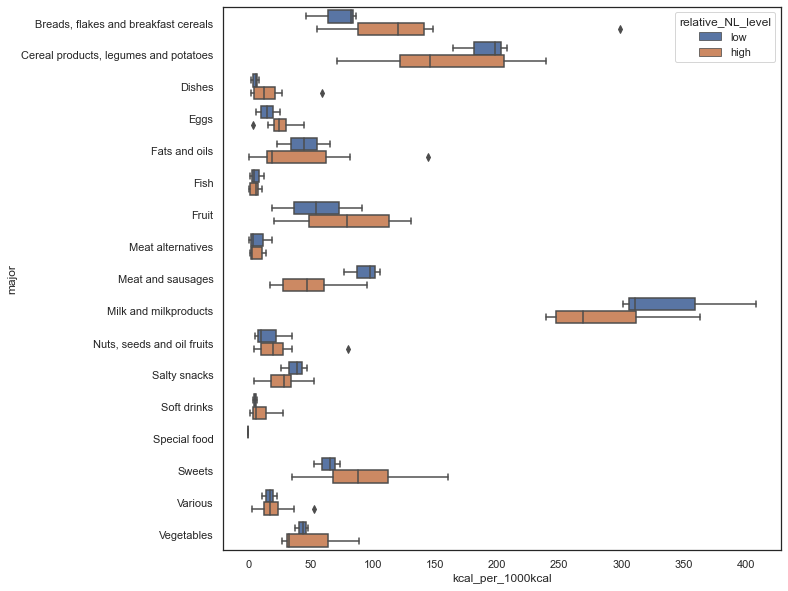

In [60]:
plt.figure(figsize=(10,10))
fig = sns.boxplot(x="kcal_per_1000kcal", y="major",
            hue="relative_NL_level", 
            data=df_majorfg_per_kcal)

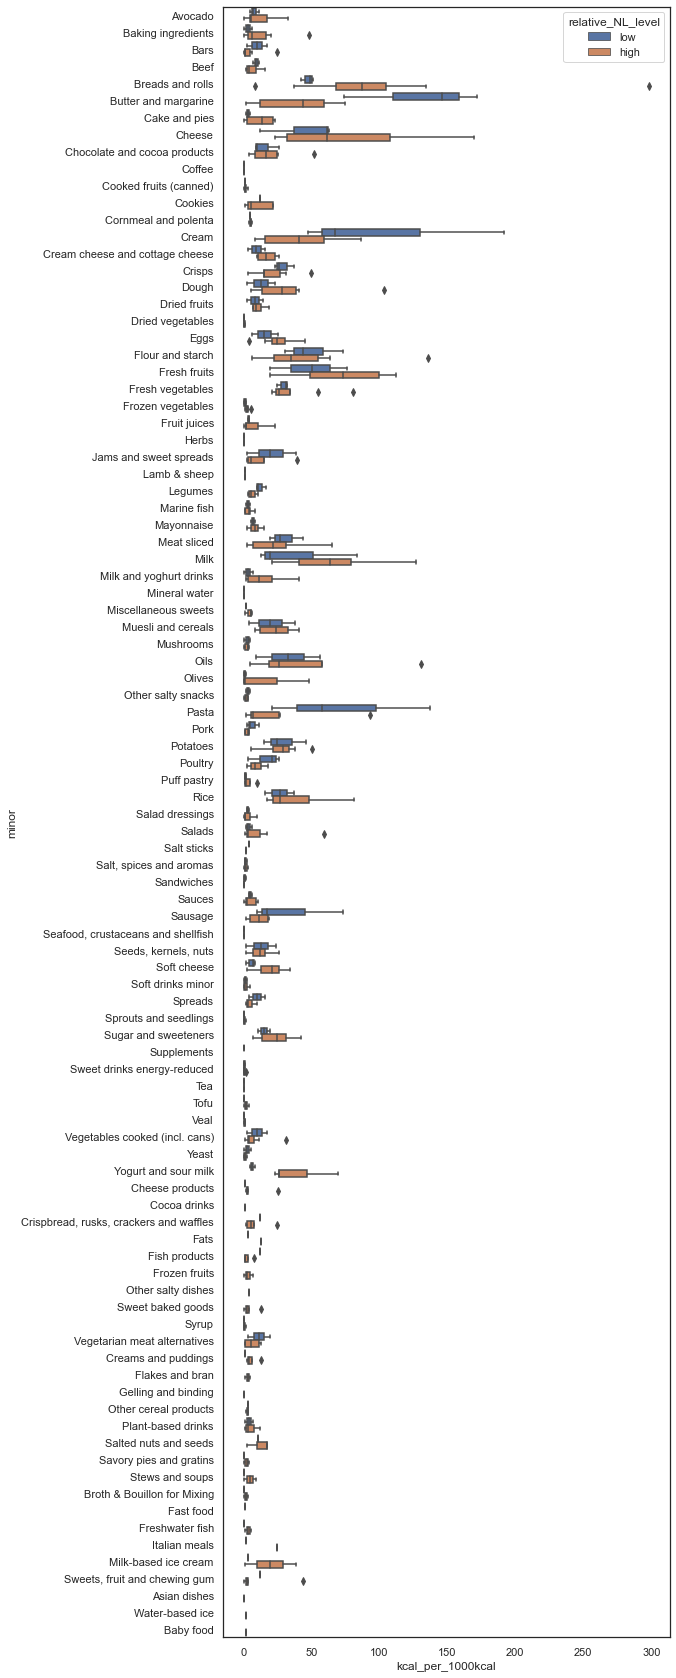

In [61]:
plt.figure(figsize=(8,30))
fig = sns.boxplot(x="kcal_per_1000kcal", y="minor",
            hue="relative_NL_level", 
            data=df_minorfg_per_kcal)


In [62]:
#Table comparing consumption of high and low NL for each food group

lst_food_group_name = df_majorfg_per_kcal["major"].unique()
lst_high_nl_consumption_mdn = []
lst_high_nl_consumption_sd = []
lst_low_nl_consumption_mdn = []
lst_low_nl_consumption_sd = []
lst_pval_mwu = []

for fg_name in df_majorfg_per_kcal["major"].unique():

    lst_high_nl_consumption_mdn.append(
        df_majorfg_per_kcal[
        (df_majorfg_per_kcal["major"] == fg_name) & (df_majorfg_per_kcal["relative_NL_level"] == "high")
        ]["kcal_per_1000kcal"].mean()
    )
    lst_high_nl_consumption_sd.append(
            df_majorfg_per_kcal[
            (df_majorfg_per_kcal["major"] == fg_name) & (df_majorfg_per_kcal["relative_NL_level"] == "high")
            ]["kcal_per_1000kcal"].std()
        )


    lst_low_nl_consumption_mdn.append(
        df_majorfg_per_kcal[
        (df_majorfg_per_kcal["major"] == fg_name) & (df_majorfg_per_kcal["relative_NL_level"] == "low")
        ]["kcal_per_1000kcal"].mean()
    )
    lst_low_nl_consumption_sd.append(
        df_majorfg_per_kcal[
        (df_majorfg_per_kcal["major"] == fg_name) & (df_majorfg_per_kcal["relative_NL_level"] == "low")
        ]["kcal_per_1000kcal"].std()
    )

    try:
        results = pg.mwu( 
            df_majorfg_per_kcal[
                (df_majorfg_per_kcal["major"] == fg_name) & (df_majorfg_per_kcal["relative_NL_level"] == "high")
                ]["kcal_per_1000kcal"], 
            df_majorfg_per_kcal[
                (df_majorfg_per_kcal["major"] == fg_name) & (df_majorfg_per_kcal["relative_NL_level"] == "low")
                ]["kcal_per_1000kcal"]
        )

        p_val = results.iloc[0][2]
        lst_pval_mwu.append(p_val)
    except:
        lst_pval_mwu.append(np.nan)

df_comparing_mj_fg = pd.DataFrame(
    {'foodgroup name': lst_food_group_name,
     'high NL Mdn': lst_high_nl_consumption_mdn,
     'high NL SD': lst_high_nl_consumption_sd,
     'low NL Mdn': lst_low_nl_consumption_mdn,
     'low NL SD': lst_low_nl_consumption_sd,
     'MWU p-val': lst_pval_mwu
    })

df_comparing_mj_fg['significance'] = np.where(df_comparing_mj_fg['MWU p-val'] < 0.05, "significant", "")

df_comparing_mj_fg.loc[(df_comparing_mj_fg['MWU p-val'] <0.05, 'significance')] = "*"
df_comparing_mj_fg.loc[(df_comparing_mj_fg['MWU p-val'] <0.01, 'significance')] = "**"
df_comparing_mj_fg.loc[(df_comparing_mj_fg['MWU p-val'] <0.001, 'significance')] = "***"

df_comparing_mj_fg = df_comparing_mj_fg.round({'high NL Mdn': 2, 'high NL SD': 2, 'low NL Mdn': 2, 'low NL SD': 2, 'MWU p-val': 3})

df_comparing_mj_fg

,foodgroup name,high NL Mdn,high NL SD,low NL Mdn,low NL SD,MWU p-val,significance
0,"Breads, flakes and breakfast cereals",130.49,75.52,71.74,22.09,0.133,
1,"Cereal products, legumes and potatoes",157.49,59.97,190.27,22.65,0.376,
2,Dishes,17.68,19.06,5.49,3.37,0.376,
3,Eggs,24.77,12.06,15.46,9.39,0.376,
4,Fats and oils,45.49,51.04,44.52,29.86,0.667,
5,Fish,5.20,4.19,6.32,5.52,0.667,
6,Fruit,79.79,41.77,54.98,36.10,0.376,
7,Meat alternatives,6.11,5.88,7.98,9.94,0.905,
8,Meat and sausages,47.73,26.02,93.58,15.28,0.024,*
9,Milk and milkproducts,285.94,49.51,340.12,58.99,0.133,


In [63]:
lst_food_group_name = df_minorfg_per_kcal["minor"].unique()
lst_high_nl_consumption_mdn = []
lst_high_nl_consumption_sd = []
lst_low_nl_consumption_mdn = []
lst_low_nl_consumption_sd = []
lst_pval_mwu = []

for fg_name in df_minorfg_per_kcal["minor"].unique():

    lst_high_nl_consumption_mdn.append(
        df_minorfg_per_kcal[
        (df_minorfg_per_kcal["minor"] == fg_name) & (df_minorfg_per_kcal["relative_NL_level"] == "high")
        ]["kcal_per_1000kcal"].mean()
    )
    lst_high_nl_consumption_sd.append(
        df_minorfg_per_kcal[
        (df_minorfg_per_kcal["minor"] == fg_name) & (df_minorfg_per_kcal["relative_NL_level"] == "high")
        ]["kcal_per_1000kcal"].std()
    )


    lst_low_nl_consumption_mdn.append(
        df_minorfg_per_kcal[
        (df_minorfg_per_kcal["minor"] == fg_name) & (df_minorfg_per_kcal["relative_NL_level"] == "low")
        ]["kcal_per_1000kcal"].mean()
    )
    lst_low_nl_consumption_sd.append(
        df_minorfg_per_kcal[
        (df_minorfg_per_kcal["minor"] == fg_name) & (df_minorfg_per_kcal["relative_NL_level"] == "low")
        ]["kcal_per_1000kcal"].std()
    )

    try:
        results = pg.mwu( 
            df_minorfg_per_kcal[
                (df_minorfg_per_kcal["minor"] == fg_name) & (df_minorfg_per_kcal["relative_NL_level"] == "high")
                ]["kcal_per_1000kcal"], 
            df_minorfg_per_kcal[
                (df_minorfg_per_kcal["minor"] == fg_name) & (df_minorfg_per_kcal["relative_NL_level"] == "low")
                ]["kcal_per_1000kcal"]
        )

        p_val = results.iloc[0][2]
        lst_pval_mwu.append(p_val)
    except:
        lst_pval_mwu.append(np.nan)

df_comparing_minj_fg = pd.DataFrame(
    {'foodgroup name': lst_food_group_name,
     'high NL Mdn': lst_high_nl_consumption_mdn,
     'high NL SD': lst_high_nl_consumption_sd,
     'low NL Mdn': lst_low_nl_consumption_mdn,
     'low NL SD': lst_low_nl_consumption_sd,
     'MWU p-val': lst_pval_mwu
    })

# indicate significance level with number of asterix
df_comparing_minj_fg.loc[(df_comparing_minj_fg['MWU p-val'] <0.05, 'significance')] = "*"
df_comparing_minj_fg.loc[(df_comparing_minj_fg['MWU p-val'] <0.01, 'significance')] = "**"
df_comparing_minj_fg.loc[(df_comparing_minj_fg['MWU p-val'] <0.001, 'significance')] = "***"

df_comparing_minj_fg = df_comparing_minj_fg.round({'high NL Mdn': 2, 'high NL SD': 2, 'low NL Mdn': 2, 'low NL SD': 2, 'MWU p-val': 3})

df_comparing_minj_fg[df_comparing_minj_fg["significance"].notna()]

,foodgroup name,high NL Mdn,high NL SD,low NL Mdn,low NL SD,MWU p-val,significance
5,Butter and margarine,37.51,29.57,130.55,50.81,0.033,*
28,Legumes,6.16,2.84,12.18,3.46,0.048,*
68,Yogurt and sour milk,37.76,18.95,6.20,1.68,0.012,*


### Exploring significant results in more detail

In [64]:
def create_jitter_boxplot(data,x="relative_NL_level", y="kcal_per_1000kcal"):
    ax = sns.boxplot(x=x, y=y, data=data, boxprops=dict(alpha=.99))
    ax = sns.stripplot(x=x, y=y, data=data, color=".3")

    print("mean kcal: ")
    print(data.groupby('relative_NL_level')["kcal_per_1000kcal"].mean())

#### Meat and Sausages

mean kcal: 
relative_NL_level
high    47.732249
low     93.583824
Name: kcal_per_1000kcal, dtype: float64


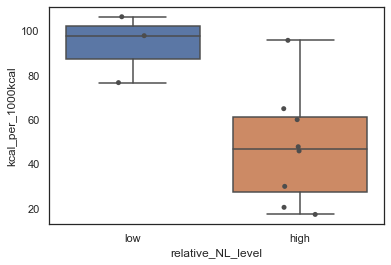

In [65]:
precut_df = df_majorfg_per_kcal[df_majorfg_per_kcal["major"]=="Meat and sausages"]

create_jitter_boxplot(x="relative_NL_level", y="kcal_per_1000kcal", data=precut_df)

In [66]:
# examining the relevant food group in more detail for statistics for writing in report

values_group1 = df_majorfg_per_kcal[
                (df_majorfg_per_kcal["major"] == "Meat and sausages") & (df_majorfg_per_kcal["relative_NL_level"] == "high")
                ]["kcal_per_1000kcal"]
values_group2 = df_majorfg_per_kcal[
                (df_majorfg_per_kcal["major"] == "Meat and sausages") & (df_majorfg_per_kcal["relative_NL_level"] == "low")
                ]["kcal_per_1000kcal"]

shortcut_mwu(values_group1, values_group2)

Mean Group 1 = 47.73225, SD Group 1 = 24.3368
Median Group 1 = 46.82328, IQR Group 1 = 33.6579
n Group 1: 8
Mean Group 2 = 93.58382, SD Group 2 = 12.47596
Median Group 2 = 97.78863, IQR Group 2 = 14.83962
n Group 2: 3
     U-val alternative     p-val       RBC      CLES
MWU    1.0   two-sided  0.024242  0.916667  0.041667
"=> Statistically significant difference between the two groups found"


#### Butter and margarine

mean kcal: 
relative_NL_level
high     37.507958
low     130.554990
Name: kcal_per_1000kcal, dtype: float64


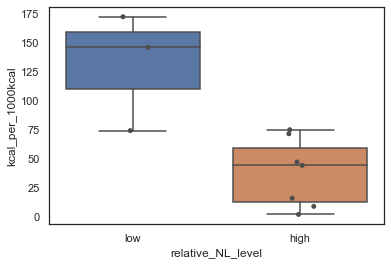

In [67]:
precut_df = df_minorfg_per_kcal[df_minorfg_per_kcal["minor"]=="Butter and margarine"]

create_jitter_boxplot(x="relative_NL_level", y="kcal_per_1000kcal", data=precut_df)


In [68]:
values_group1 = df_minorfg_per_kcal[(df_minorfg_per_kcal["minor"]=="Butter and margarine") & (df_minorfg_per_kcal["relative_NL_level"]=="high")]["kcal_per_1000kcal"]
values_group2 = df_minorfg_per_kcal[(df_minorfg_per_kcal["minor"]=="Butter and margarine") & (df_minorfg_per_kcal["relative_NL_level"]=="low")]["kcal_per_1000kcal"]

shortcut_mwu(values_group1, values_group2)

Mean Group 1 = 37.50796, SD Group 1 = 27.37597
Median Group 1 = 43.95649, IQR Group 1 = 46.8878
n Group 1: 7
Mean Group 2 = 130.55499, SD Group 2 = 41.4858
Median Group 2 = 145.67485, IQR Group 2 = 49.09328
n Group 2: 3
     U-val alternative     p-val       RBC      CLES
MWU    1.0   two-sided  0.033333  0.904762  0.047619
"=> Statistically significant difference between the two groups found"


#### Legumes

mean kcal: 
relative_NL_level
high     6.159538
low     12.182279
Name: kcal_per_1000kcal, dtype: float64


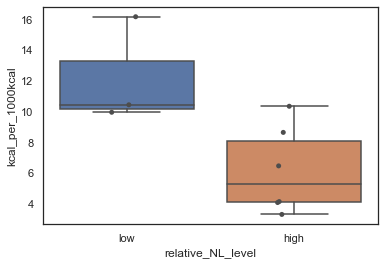

In [69]:
precut_df = df_minorfg_per_kcal[df_minorfg_per_kcal["minor"]=="Legumes"]

create_jitter_boxplot(x="relative_NL_level", y="kcal_per_1000kcal", data=precut_df)


In [70]:
values_group1 = df_minorfg_per_kcal[(df_minorfg_per_kcal["minor"]=="Legumes") & (df_minorfg_per_kcal["relative_NL_level"]=="high")]["kcal_per_1000kcal"]
values_group2 = df_minorfg_per_kcal[(df_minorfg_per_kcal["minor"]=="Legumes") & (df_minorfg_per_kcal["relative_NL_level"]=="low")]["kcal_per_1000kcal"]

shortcut_mwu(values_group1, values_group2)

Mean Group 1 = 6.15954, SD Group 1 = 2.59141
Median Group 1 = 5.29942, IQR Group 1 = 4.00242
n Group 1: 6
Mean Group 2 = 12.18228, SD Group 2 = 2.82175
Median Group 2 = 10.43516, IQR Group 2 = 3.1071
n Group 2: 3
     U-val alternative     p-val       RBC      CLES
MWU    1.0   two-sided  0.047619  0.888889  0.055556
"=> Statistically significant difference between the two groups found"


#### Yogurt and sour milk

mean kcal: 
relative_NL_level
high    37.761022
low      6.202017
Name: kcal_per_1000kcal, dtype: float64


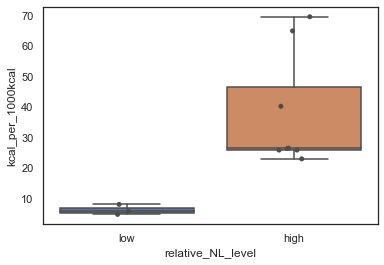

In [71]:
precut_df = df_minorfg_per_kcal[df_minorfg_per_kcal["minor"]=="Yogurt and sour milk"]

create_jitter_boxplot(x="relative_NL_level", y="kcal_per_1000kcal", data=precut_df)


In [72]:
values_group1 = df_minorfg_per_kcal[(df_minorfg_per_kcal["minor"]=="Yogurt and sour milk") & (df_minorfg_per_kcal["relative_NL_level"]=="high")]["kcal_per_1000kcal"]
values_group2 = df_minorfg_per_kcal[(df_minorfg_per_kcal["minor"]=="Yogurt and sour milk") & (df_minorfg_per_kcal["relative_NL_level"]=="low")]["kcal_per_1000kcal"]

shortcut_mwu(values_group1, values_group2)

Mean Group 1 = 37.76102, SD Group 1 = 17.7267
Median Group 1 = 26.40768, IQR Group 1 = 20.5319
n Group 1: 8
Mean Group 2 = 6.20202, SD Group 2 = 1.3725
Median Group 2 = 5.80883, IQR Group 2 = 1.64611
n Group 2: 3
     U-val alternative     p-val  RBC  CLES
MWU   24.0   two-sided  0.012121 -1.0   1.0
"=> Statistically significant difference between the two groups found"
